# Background information


## Introduction to locational marginal price (LMP)

Since the liberalization of the U.S. market, most U.S. electric markets adopt the locational marginal price (LMP) to set prices for energy purchases and sales. The power market is usually divided into the day-ahead (DA) market and real-time (RT) market. The resolution of the DA market is one hour. In DA market before the operation day, Generation companies (GENCOs) and large consumers bid in the DA market and receive the LMP when ISO clears the market by running an economic dispatch problem. Then in the operation day, ISO will clear the RT market again and calculate the RT LMP. The cleared DA and RT LMP are used in the settlement phase, where consumers pay the LMP and GENCOs receive LMP. 

The detailed of LMP calculation can be refered at https://www.iso-ne.com/participate/support/faq/lmp. 


## Why LMP is important and the purpose of this report 

True to its name, LMP is location-dependent. It is also influenced by demand, renewable energy generation, transmission congestion, prices of fuel, generator outage, etc. LMP is not only the energy price for transactions but also a critical index for the decision-making of the market participants. Therefore, accurate electricity forecasting is a key issue for both market participants and market operators in the wholesale electricity market. Market participants forecast LMP to help themselves bid to maximize their profit; market operators need to forecast LMP to identify possible peercises of market power and detect unreasonable prices [1]. 

This report takes a look at the general trend of LMP and its correlation with other time-series data, such as load, temperature, and fuel mix. This works can serve as a data preprocessing for performing LMP forecasting using machine learning methods in the future.

## Data source
In this report, we analyze data from PJM of three years (7/1/2018 00:00 to 5/31/2021 23:59). The collected data include:

Target:  
- DA LMP: https://dataminer2.pjm.com/feed/rt_da_monthly_lmps, node: 1(PJM RTO)  

We select the following accomapying data sets to assist our understanding of LMP:  
- DA_load: https://dataminer2.pjm.com/feed/hrl_load_metered, Region: RTO
- DA_wind: https://dataminer2.pjm.com/feed/wind_gen , area: RTO
- DA_temperature: https://dataminer2.pjm.com/feed/da_tempset 
- fuel_type: https://dataminer2.pjm.com/feed/gen_by_fuel
- outage: https://dataminer2.pjm.com/feed/gen_outages_by_type, region: PJM RTO

[1] G. Li, C. Liu, C. Mattson and J. Lawarree, "Day-Ahead Electricity Price Forecasting in a Grid Environment," in IEEE Transactions on Power Systems, vol. 22, no. 1, pp. 266-274, Feb. 2007, doi: 10.1109/TPWRS.2006.887893.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
date_range = pd.date_range('7/1/2018','5/31/2021',  freq='H') #predifined the time-range

#help turn reindex a DataFrame with time-stamp and only keep the important data columns
def index_to_datetime( index_col, df, data_col,pass_index=False, date_range=date_range):
    """
    given df, reindex df by the column index_col (optional),  
    use UTC time stamp plus 5 hours (Eastern standard time without daylight saving) as our index, sord index, and 
    extract data column, then return dataframe of desired data_range.
    """
    if pass_index==False:
        df=df.set_index(index_col)
    df.index= pd.to_datetime(df.index)  - timedelta(hours=5)
    df=df.sort_index()
    df=df[[data_col]]
    return df.loc[date_range]

plt.rcParams["figure.figsize"] = [10, 5]

# 1. Read in the data
Due to regulation of the PJM webset, only one-year's data can be downloaded each time. We download each year's data and concatenate them into one complete dataframe.

We then reindex the dataframe with nonrepetitive time stamp. PJM uses time zone EPT, which includes daylight savings. We will use the UTC time stamp plus 5 hours (Eastern standard time without daylight saving) as our index. 
 

In [3]:
# Read in target LMP data
LMP_data_1=pd.read_csv('data/2018.6-2019.6_rt_da_monthly_lmps.csv')
LMP_data_2=pd.read_csv('data/2019.6-2020.6_rt_da_monthly_lmps.csv')
LMP_data_3=pd.read_csv('data/target_rt_da_monthly_lmps.csv')
LMP_data =pd.concat([LMP_data_1,LMP_data_2,LMP_data_3],axis=0)
LMP_data.head()
# LMP_data.plot()

,datetime_beginning_utc,datetime_beginning_ept,pnode_id,pnode_name,voltage,equipment,type,zone,system_energy_price_rt,total_lmp_rt,congestion_price_rt,marginal_loss_price_rt,system_energy_price_da,total_lmp_da,congestion_price_da,marginal_loss_price_da
0,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,1,PJM,NaN,NaN,ZONE,NaN,19.583333,19.592010,0.0,0.008677,22.74,22.508851,-0.209312,-0.021837
1,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,1,PJM,NaN,NaN,ZONE,NaN,19.640833,19.651624,0.0,0.010791,20.34,20.235280,-0.081750,-0.022970
2,6/1/2018 6:00:00 AM,6/1/2018 2:00:00 AM,1,PJM,NaN,NaN,ZONE,NaN,18.746667,18.756331,0.0,0.009664,19.23,19.096447,-0.100270,-0.033283
3,6/1/2018 7:00:00 AM,6/1/2018 3:00:00 AM,1,PJM,NaN,NaN,ZONE,NaN,17.512500,17.521583,0.0,0.009083,18.75,18.621263,-0.105012,-0.023725
4,6/1/2018 8:00:00 AM,6/1/2018 4:00:00 AM,1,PJM,NaN,NaN,ZONE,NaN,17.273333,17.281782,0.0,0.008449,18.67,18.559338,-0.086773,-0.023889


In [4]:
LMP=index_to_datetime('datetime_beginning_utc', LMP_data,'total_lmp_da')
print(LMP.index[0],LMP.index[-1])

2018-07-01 00:00:00 2021-05-31 00:00:00


Text(0.5, 1.0, 'Histogram of historical LMP')

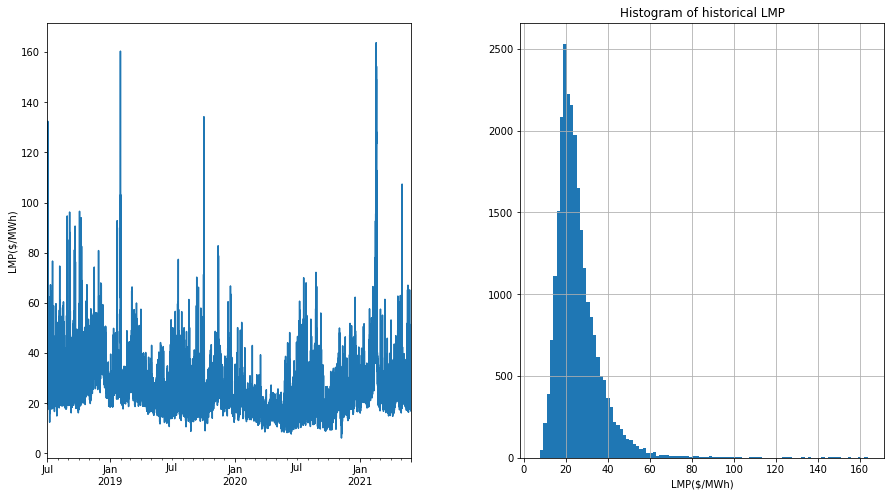

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
 
LMP.plot(ax=ax[0],legend=None)
ax[0].set_ylabel('LMP($/MWh)')
LMP.hist(bins=100,ax=ax[1])
ax[1].set_xlabel('LMP($/MWh)')
ax[1].set_title('Histogram of historical LMP')

In [6]:
# Read input data 1: load
load_data_1=pd.read_csv('data/2018.6-2019.6_hrl_load_metered.csv')
load_data_2=pd.read_csv('data/2019.6-2020.6_hrl_load_metered.csv')
load_data_3=pd.read_csv('data/1_hrl_load_metered.csv')
load_data =pd.concat([load_data_1,load_data_2,load_data_3],axis=0)
load_data.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,RTO,RTO,RTO,RTO,85824.931,False
1,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,RTO,RTO,RTO,RTO,80611.968,False
2,6/1/2018 6:00:00 AM,6/1/2018 2:00:00 AM,RTO,RTO,RTO,RTO,77403.692,False
3,6/1/2018 7:00:00 AM,6/1/2018 3:00:00 AM,RTO,RTO,RTO,RTO,75483.798,False
4,6/1/2018 8:00:00 AM,6/1/2018 4:00:00 AM,RTO,RTO,RTO,RTO,75596.412,False


In [7]:
load=index_to_datetime('datetime_beginning_utc', load_data,'mw')
print(load.index[0], load.index[-1])

2018-07-01 00:00:00 2021-05-31 00:00:00


Text(0.5, 1.0, 'Histogram of day-ahead load')

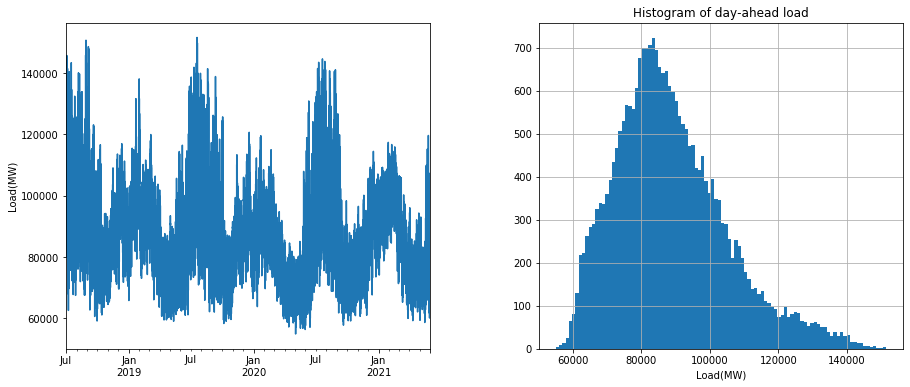

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
 
load.plot(ax=ax[0],legend=None)
ax[0].set_ylabel('Load(MW)')
load.hist(bins=100,ax=ax[1])
ax[1].set_xlabel('Load(MW)')
ax[1].set_title('Histogram of day-ahead load')

In [9]:
# Read input data 2: wind
wind_data_1 = pd.read_csv('data/2018.6-2019.6_wind_gen.csv')
wind_data_2 = pd.read_csv('data/2019.6-2020.6_wind_gen.csv')
wind_data_3 = pd.read_csv('data/2_wind_gen.csv')
wind_data =pd.concat([wind_data_1,wind_data_2,wind_data_3],axis=0)
wind_data.head()

,datetime_beginning_utc,datetime_beginning_ept,area,wind_generation_mw
0,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,RTO,1531.783
1,6/1/2018 5:00:00 AM,6/1/2018 1:00:00 AM,RTO,1637.612
2,6/1/2018 6:00:00 AM,6/1/2018 2:00:00 AM,RTO,1354.959
3,6/1/2018 7:00:00 AM,6/1/2018 3:00:00 AM,RTO,1222.521
4,6/1/2018 8:00:00 AM,6/1/2018 4:00:00 AM,RTO,1225.327


In [10]:
wind=index_to_datetime('datetime_beginning_utc', wind_data,'wind_generation_mw')
print(wind.index[0], wind.index[-1])

2018-07-01 00:00:00 2021-05-31 00:00:00


In [11]:
# Read input data 3: solar. But solar data is only available from 1/1/2019.  
solar_data_1 = pd.read_csv('data/2018.6-2019.6_solar_gen.csv')
solar_data_2 = pd.read_csv('data/2019.6-2020.6_solar_gen.csv')
solar_data_3 = pd.read_csv('data/3_solar_gen.csv')
solar_data = pd.concat([solar_data_1,solar_data_2,solar_data_3],axis=0)
solar_data.head()

,datetime_beginning_utc,datetime_beginning_ept,area,solar_generation_mw
0,1/1/2019 5:00:00 AM,1/1/2019 12:00:00 AM,RTO,-1.773
1,1/1/2019 6:00:00 AM,1/1/2019 1:00:00 AM,RTO,-1.816
2,1/1/2019 7:00:00 AM,1/1/2019 2:00:00 AM,RTO,-1.760
3,1/1/2019 8:00:00 AM,1/1/2019 3:00:00 AM,RTO,-1.801
4,1/1/2019 9:00:00 AM,1/1/2019 4:00:00 AM,RTO,-1.797


In [12]:
solar=index_to_datetime('datetime_beginning_utc', solar_data, 'solar_generation_mw',date_range=pd.date_range('1/1/2019','5/31/2021',  freq='H'))
print(solar.index[0], solar.index[-1])

2019-01-01 00:00:00 2021-05-31 00:00:00


In [13]:
# Read input data 4: temperature
temp_data_1 = pd.read_csv('data/2018.6-2019.6_da_tempset.csv')
temp_data_2 = pd.read_csv('data/2019.6-2020.6_da_tempset.csv')
temp_data_3 = pd.read_csv('data/4_da_tempset.csv')
temp_data =pd.concat([temp_data_1,temp_data_2,temp_data_3],axis=0)
temp_data.head()

,datetime_beginning_utc,datetime_beginning_ept,datetime_ending_utc,datetime_ending_ept,zone,da_temperature_set
0,7/1/2018 4:00:00 AM,7/1/2018 12:00:00 AM,7/1/2018 7:00:00 AM,7/1/2018 3:00:00 AM,AE,86-NIGHT
1,7/1/2018 4:00:00 AM,7/1/2018 12:00:00 AM,7/1/2018 5:00:00 AM,7/1/2018 1:00:00 AM,AEP,86-NIGHT
2,7/1/2018 4:00:00 AM,7/1/2018 12:00:00 AM,7/1/2018 5:00:00 AM,7/1/2018 1:00:00 AM,AP,86-NIGHT
3,7/1/2018 4:00:00 AM,7/1/2018 12:00:00 AM,7/1/2018 5:00:00 AM,7/1/2018 1:00:00 AM,ATSI,86-NIGHT
4,7/1/2018 4:00:00 AM,7/1/2018 12:00:00 AM,7/1/2018 7:00:00 AM,7/1/2018 3:00:00 AM,BC,86-NIGHT


Noticing that temparature data includes multiple zones, we calculate the average temparature among all zones as our temperature data.

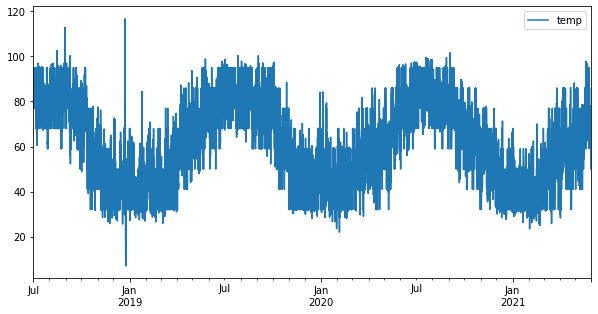

In [14]:
temp_data['temp']=temp_data.da_temperature_set.str.extract('(\d+)').astype(float)
temp_data_reformt = temp_data[['datetime_ending_utc','temp']].groupby('datetime_ending_utc').mean()
temp_data_reformt.index= pd.to_datetime(temp_data_reformt.index) - timedelta(hours=5)
temp_data_reformt=temp_data_reformt.sort_index() #this df still has missing rows 
temp_data_reformt=temp_data_reformt.reindex(date_range) #expand index to full timeline
temp=temp_data_reformt.interpolate(method='polynomial', order=2) 
temp.plot()

In [15]:
# Read input data 5:  Read fuel component
fuel_data_1=pd.read_csv('data/2018.6-2019.6_gen_by_fuel.csv')
fuel_data_2=pd.read_csv('data/2019.6-2020.6_gen_by_fuel.csv')
fuel_data_3=pd.read_csv('data/5_gen_by_fuel.csv')
fuel_data=pd.concat([fuel_data_1,fuel_data_2,fuel_data_3],axis=0)
fuel_data.head()

,datetime_beginning_utc,datetime_beginning_ept,fuel_type,mw,fuel_percentage_of_total,is_renewable
0,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,Coal,25380.7,0.27,False
1,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,Gas,28636.7,0.31,False
2,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,Hydro,1340.8,0.01,True
3,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,Multiple Fuels,255.3,0.00,False
4,6/1/2018 4:00:00 AM,6/1/2018 12:00:00 AM,Nuclear,34183.7,0.37,False


We want to expand the different fuel_type into different columns. To make a "long" dataframe "wide", we use the "pivot" method.

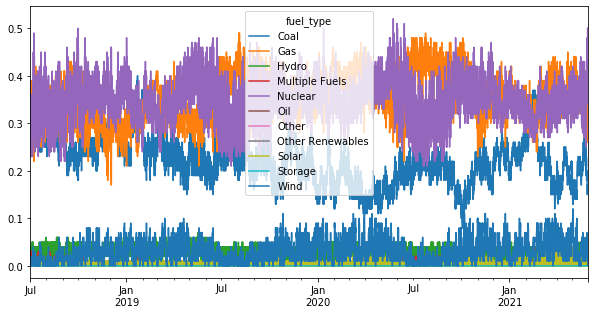

In [16]:
fuel_reformat=fuel_data.pivot(index='datetime_beginning_utc', columns='fuel_type', values='fuel_percentage_of_total')
fuel_reformat.index= pd.to_datetime(fuel_reformat.index) - timedelta(hours=5)
fuel_reformat=fuel_reformat.sort_index()
fuel_reformat=fuel_reformat.reindex(date_range)
fuel=fuel_reformat.fillna(fuel_reformat.mean())
fuel.plot()

In [19]:
fuel.describe()

fuel_type,Coal,Gas,Hydro,Multiple Fuels,Nuclear,Oil,Other,Other Renewables,Solar,Storage,Wind
count,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.0,25561.000000
mean,0.223031,0.361312,0.020250,0.005165,0.344721,0.000456,0.000058,0.006167,0.003486,0.0,0.031741
std,0.049741,0.047193,0.012154,0.005977,0.047730,0.002279,0.000759,0.004862,0.006230,0.0,0.023620
min,0.080000,0.170000,0.000000,0.000000,0.210000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.190000,0.330000,0.010000,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,0.0,0.010000
50%,0.220000,0.360000,0.020000,0.000000,0.340000,0.000000,0.000000,0.010000,0.000000,0.0,0.030000
75%,0.250000,0.400000,0.030000,0.010000,0.380000,0.000000,0.000000,0.010000,0.010000,0.0,0.050000
max,0.400000,0.490000,0.070000,0.030000,0.520000,0.050000,0.010000,0.010000,0.040000,0.0,0.120000


In [20]:
#notice that "Storage" column contains only 0, it is reasonable to drop this column. 
fuel.drop('Storage',axis=1,inplace=True)

In [17]:
#Read input data 6: outage
outage_data_1=pd.read_csv('data/2018.6-2019.6_gen_outages_by_type.csv')
outage_data_2=pd.read_csv('data/2019.6-2020.6_gen_outages_by_type.csv')
outage_data_3=pd.read_csv('data/6_gen_outages_by_type.csv')
outage_data=pd.concat([outage_data_1,outage_data_2,outage_data_3],axis=0)
outage_data.head()

,forecast_execution_date_ept,forecast_date,region,total_outages_mw,planned_outages_mw,maintenance_outages_mw,forced_outages_mw
0,6/1/2018 12:00:00 AM,6/1/2018 12:00:00 AM,PJM RTO,28781,9533,6591,12657
1,6/1/2018 12:00:00 AM,6/2/2018 12:00:00 AM,PJM RTO,29304,10116,11767,7421
2,6/2/2018 12:00:00 AM,6/2/2018 12:00:00 AM,PJM RTO,31038,9050,10871,11117
3,6/1/2018 12:00:00 AM,6/3/2018 12:00:00 AM,PJM RTO,26827,9454,10241,7132
4,6/2/2018 12:00:00 AM,6/3/2018 12:00:00 AM,PJM RTO,29002,8690,11596,8716


In [18]:
outage=outage_data.drop_duplicates(subset=['forecast_date'], keep='last')
outage=outage.set_index('forecast_date')
outage.index= pd.to_datetime(outage.index) #-timedelta(hours=1)
outage=outage.sort_index()
outage

,forecast_execution_date_ept,region,total_outages_mw,planned_outages_mw,maintenance_outages_mw,forced_outages_mw
forecast_date,,,,,,
2018-06-01,6/1/2018 12:00:00 AM,PJM RTO,28781,9533,6591,12657
2018-06-02,6/2/2018 12:00:00 AM,PJM RTO,31038,9050,10871,11117
2018-06-03,6/3/2018 12:00:00 AM,PJM RTO,31367,8677,11677,11013
2018-06-04,6/4/2018 12:00:00 AM,PJM RTO,27444,8164,9891,9389
2018-06-05,6/5/2018 12:00:00 AM,PJM RTO,30251,7774,12402,10075
...,...,...,...,...,...,...
2021-06-03,5/28/2021 12:00:00 AM,PJM RTO,18623,12651,4633,1339
2021-06-04,5/29/2021 12:00:00 AM,PJM RTO,20851,12567,6684,1600
2021-06-05,5/30/2021 12:00:00 AM,PJM RTO,22156,12389,8213,1554


 ## Combine all data together
 
Solar data is only available from 1/1/2019. The outage data is for a whole day. We will skip these two datasets for now and analyze them seperately.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002892C9392B0>,
      dtype=object)

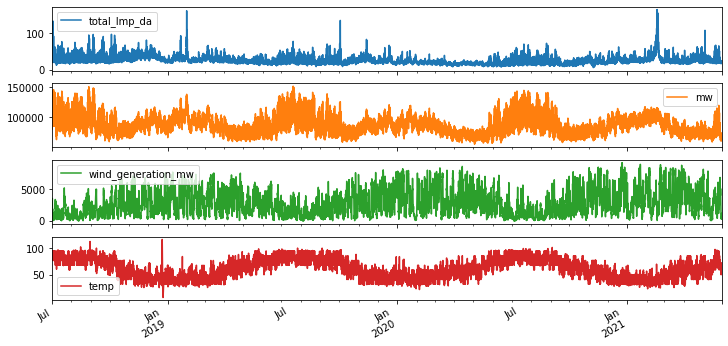

In [19]:
total_data = pd.concat([LMP,load,wind,temp,fuel],axis=1)
total_data[['total_lmp_da', 'mw', 'wind_generation_mw','temp']].plot(subplots=True,figsize=(12,6))

# 2: Carry out analysis for business questions.
## 2.1 What factors determine the general trend of the LMP?

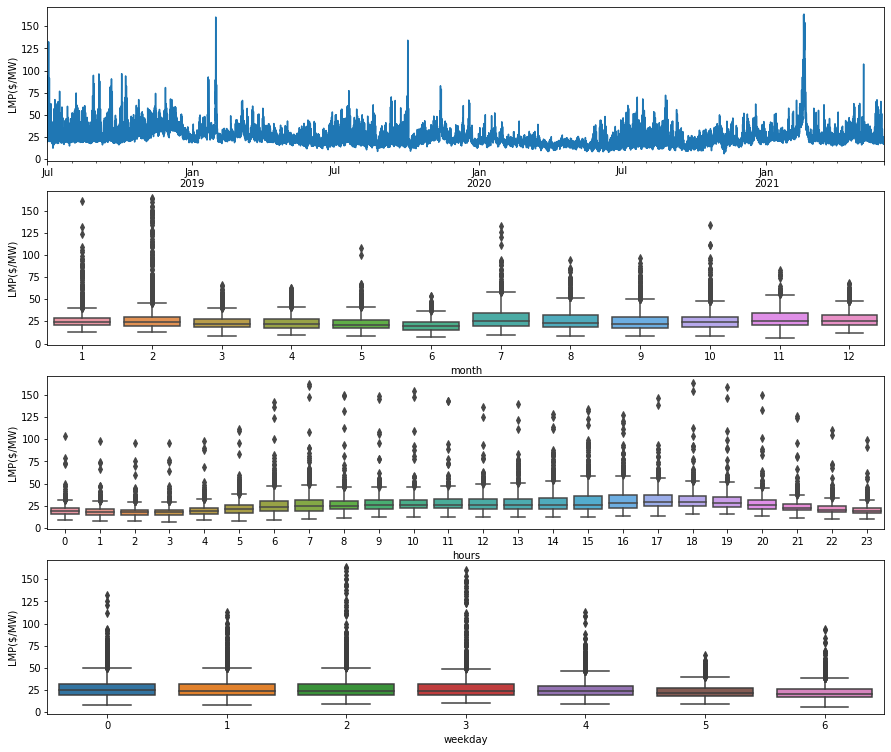

In [20]:
fig, ax = plt.subplots(4,1, figsize=(15,13))
# LMP.plot()
# ax.shape = (2,2)
LMP.plot(ax=ax[0],legend=None)
sns.boxplot(x=LMP.index.month , y= 'total_lmp_da', data=LMP, ax=ax[1])
ax[1].set_xlabel('month')
sns.boxplot(x=LMP.index.hour , y= 'total_lmp_da', data=LMP,ax=ax[2])
ax[2].set_xlabel('hours')
sns.boxplot(x=LMP.index.weekday , y= 'total_lmp_da', data=LMP,ax=ax[3])
ax[3].set_xlabel('weekday')
for subax in ax:
    subax.set_ylabel('LMP($/MW)')

### Answer:
From the above figures, we observe that LMP has monthly, daily and hourly trend. LMP is lower during spring and fall monthes, and higher during summer and winter monthes. Within a day, LMP is lowest during evening hours, and gradually increases during the day time. LMP from Monday to Friday have similar mean values, but the mean LMP during Sateurday and Sunday are obviously lower than that of Monday to Friday. Theses trends coincide with the electric load trend, which is heavier during winter and summer due to heating/cooling, and during weekday than weekend. If we want to perform LMP forecast using machine learning later, the date should be taken as an input feature.

# 2.2 What is the correlation relationship between LMP and other time-series data? 

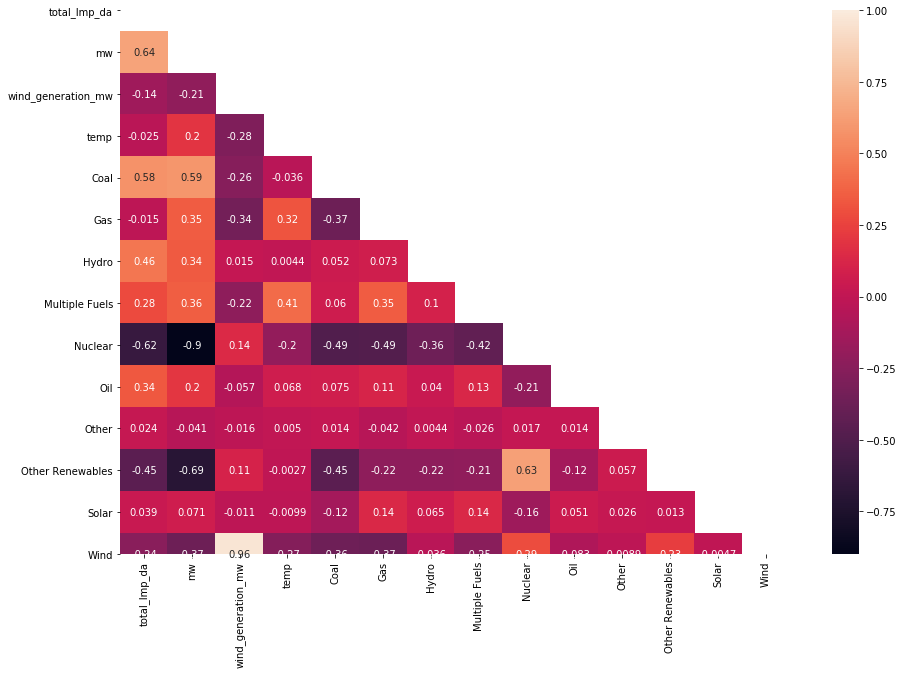

In [21]:
f, ax = plt.subplots(figsize=(15, 10))
corr=total_data.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True,mask=matrix)

In [22]:
corr

,total_lmp_da,mw,wind_generation_mw,temp,Coal,Gas,Hydro,Multiple Fuels,Nuclear,Oil,Other,Other Renewables,Solar,Wind
total_lmp_da,1.000000,0.644635,-0.143077,-0.025049,0.576386,-0.015246,0.457583,0.282563,-0.622834,0.336416,0.023890,-0.448042,0.038642,-0.239981
mw,0.644635,1.000000,-0.211374,0.196864,0.588676,0.352329,0.340659,0.358546,-0.899084,0.204968,-0.041428,-0.693947,0.071371,-0.371209
wind_generation_mw,-0.143077,-0.211374,1.000000,-0.284514,-0.255925,-0.337933,0.015151,-0.220884,0.143529,-0.057244,-0.016278,0.109227,-0.011003,0.964609
temp,-0.025049,0.196864,-0.284514,1.000000,-0.035647,0.323992,0.004420,0.411130,-0.199352,0.068321,0.005020,-0.002730,-0.009899,-0.266806
Coal,0.576386,0.588676,-0.255925,-0.035647,1.000000,-0.366732,0.051880,0.059664,-0.492355,0.074739,0.014216,-0.450050,-0.120623,-0.361669
Gas,-0.015246,0.352329,-0.337933,0.323992,-0.366732,1.000000,0.073157,0.351527,-0.486464,0.111628,-0.042221,-0.216881,0.135553,-0.374256
Hydro,0.457583,0.340659,0.015151,0.004420,0.051880,0.073157,1.000000,0.100393,-0.360685,0.039674,0.004372,-0.223554,0.064773,-0.036238
Multiple Fuels,0.282563,0.358546,-0.220884,0.411130,0.059664,0.351527,0.100393,1.000000,-0.419695,0.125871,-0.026262,-0.213931,0.137815,-0.246079
Nuclear,-0.622834,-0.899084,0.143529,-0.199352,-0.492355,-0.486464,-0.360685,-0.419695,1.000000,-0.206027,0.016543,0.632147,-0.156570,0.291396
Oil,0.336416,0.204968,-0.057244,0.068321,0.074739,0.111628,0.039674,0.125871,-0.206027,1.000000,0.014149,-0.124789,0.050929,-0.082682


In [23]:
# Calculate LMP's correlation with solar power.
solar['lmp']=LMP.loc[solar.index]
corr_solar=solar.corr()
corr_solar

,solar_generation_mw,lmp
solar_generation_mw,1.000000,0.146984
lmp,0.146984,1.000000


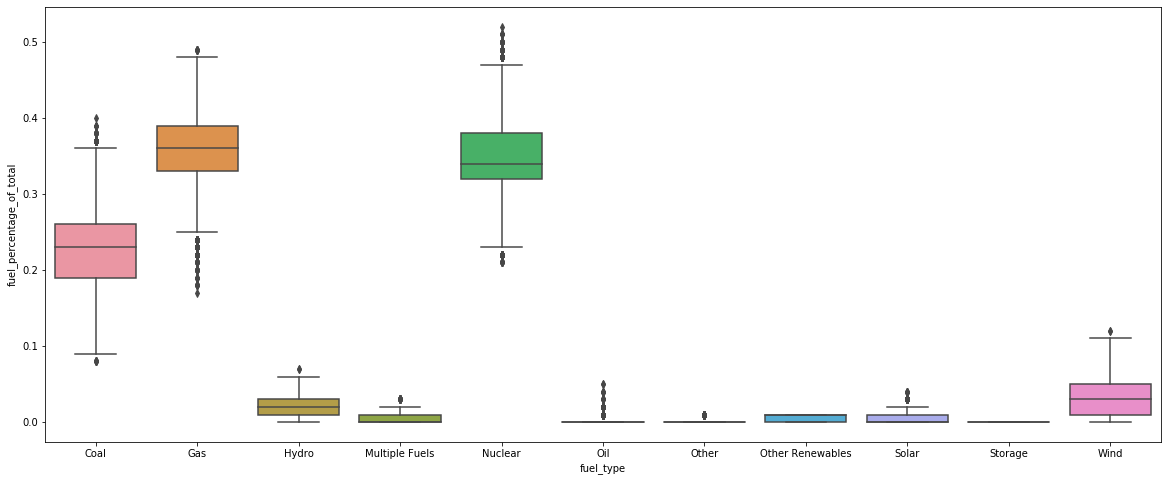

In [24]:
fig= plt.figure(figsize=(20,8))
sns.boxplot(x=fuel_data.fuel_type , y= 'fuel_percentage_of_total', data=fuel_data )

### Answer:
Here we look at the correlation among the time-series data. 
We are most interested in the LMP's correlation with other data, so we will first look at the first column of the correlation heatmap. In this heatmap, we can see that LMP has a 0.64 correlation with the load data, highest among all data. This consolidates that observation from the 2.1 that LMP exibits similar monthly, weekly and hourly trends with load. This is also reasonable in theory, as LMP has component of the energy balance constraint dual variable, which is directly related with load level. Interestingly, temperature and load as a 0.2 correlation, but it seems LMP is not correlated with temperature. 

Since the ED problem minimizes the total cost of energy purchase, the fuel mix of the generation should influence LMP. In the fule mix boxplot, we can observe that gas-burninig generators consitutes about 37% of the total generation in average, which is the highest among all fuel types, followed by coal-fired units and nuclear units. Renewable energy contributed less than 10% of the generation, with wind power among the highest one. Since coal and gas power has a higher cost, while wind power has zero marginal cost, it is expected that LMP will be higher the traditional generators takers higher portion, and lower if renewables are dominant. 
In the correlation heatmap, we observe LMP has positive correlation with fossil fuels such as coal and oil, and negative correlation with nuclear, gas, and other renewable energies (except for solar and hydro). This shows that load and generation fuel mix data (should be available to ISO) can assist in LMP forecast. Fuel prices can be also taken into consideration.

# 2.3 How is the autocorrelation of the LMP?

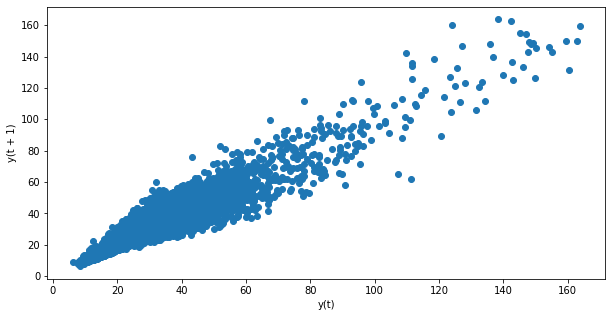

In [25]:
pd.plotting.lag_plot(total_data['total_lmp_da'],lag=1)

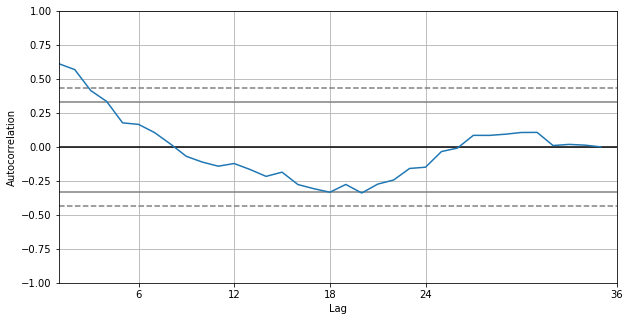

In [26]:
pd.plotting.autocorrelation_plot(total_data['total_lmp_da'].resample('1m').mean() )
_=plt.xticks([6,12,18,24,36])

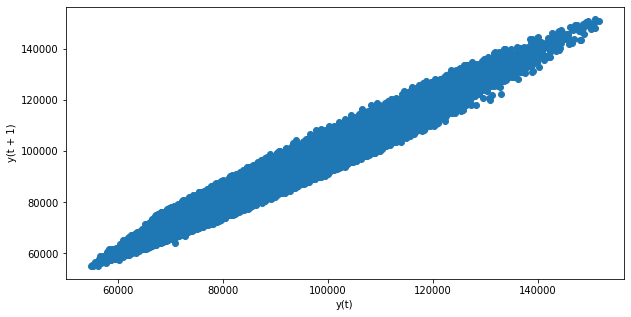

In [27]:
pd.plotting.lag_plot(total_data['mw'],lag=1)

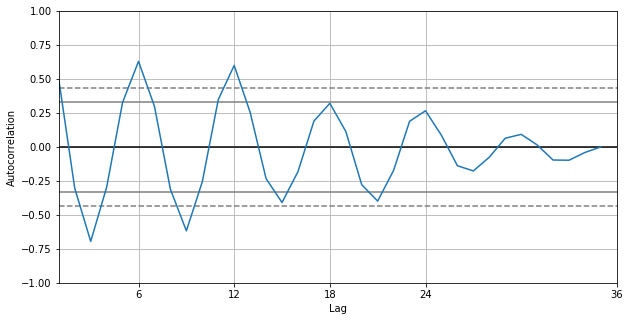

In [28]:
pd.plotting.autocorrelation_plot(total_data['mw'].resample('1m').mean())
_=plt.xticks([6,12,18,24,36])

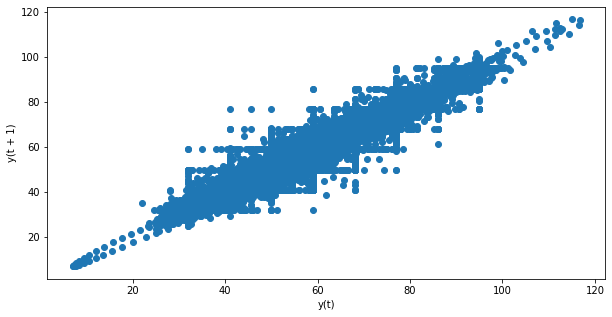

In [29]:
pd.plotting.lag_plot(total_data['temp'],lag=1)

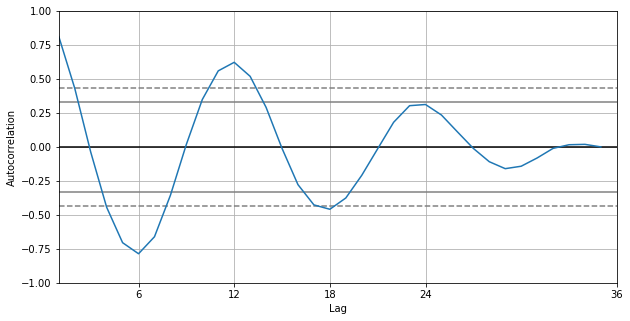

In [30]:
pd.plotting.autocorrelation_plot(total_data['temp'].resample('1m').mean())
_=plt.xticks([6,12,18,24,36])

### Answer:
We made lag plots of the data. Some interesting facts about lag plot can be found in https://www.geeksforgeeks.org/lag-plots/ and https://www.youtube.com/watch?v=3sH1kisAK9s&list=LL&index=7. Lag plots can be used to answer the question about the distribution of model, randomness indata, and autocorrelation.  If the lag plot gives a linear plot, then it means the autocorrelation is strong in the data. 
The lag plot of LMP (lag=1) is concentrated on the diagonal line, meaning there is moderate to strong autocorrelation. Strong autocorrelation is shown in the load and temperature's lag plot.

The autocorrelation plot on temparature shows strong yearly trend, meaning that temparature each year follows similar trend. The autocorrelation plot on load indicates that the load every half year follows similar trend. However, LMP does not show significant seasonality in the autocorrelation plot, indicating that many factors can contribute to LMP. It also indicates that LMP prediction would be more complex than load forecast or temparature forecast.  

# 2.4 Does outage impact the LMP?

In [31]:
total_data['day']=total_data.index.strftime('%y-%m-%d')
total_data

,total_lmp_da,mw,wind_generation_mw,temp,Coal,Gas,Hydro,Multiple Fuels,Nuclear,Oil,Other,Other Renewables,Solar,Wind,day
2018-07-01 00:00:00,24.384202,92976.107,2561.371,86.000000,0.34,0.28,0.01,0.01,0.33,0.0,0.0,0.01,0.0,0.02,18-07-01
2018-07-01 01:00:00,21.163480,87766.855,2310.323,85.756831,0.33,0.28,0.00,0.01,0.34,0.0,0.0,0.01,0.0,0.02,18-07-01
2018-07-01 02:00:00,20.396348,84127.256,2025.389,86.000000,0.32,0.28,0.01,0.01,0.36,0.0,0.0,0.01,0.0,0.02,18-07-01
2018-07-01 03:00:00,19.811949,81591.718,1975.352,86.000000,0.31,0.27,0.01,0.01,0.37,0.0,0.0,0.01,0.0,0.02,18-07-01
2018-07-01 04:00:00,19.517686,80353.197,1805.501,81.379784,0.30,0.28,0.01,0.01,0.38,0.0,0.0,0.01,0.0,0.02,18-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30 20:00:00,24.883801,72245.445,246.080,68.000000,0.17,0.36,0.04,0.00,0.42,0.0,0.0,0.01,0.0,0.00,21-05-30
2021-05-30 21:00:00,21.746204,69622.075,394.110,68.000000,0.17,0.36,0.01,0.00,0.44,0.0,0.0,0.01,0.0,0.01,21-05-30
2021-05-30 22:00:00,19.203838,66568.778,631.698,61.700000,0.17,0.33,0.01,0.00,0.46,0.0,0.0,0.01,0.0,0.01,21-05-30
2021-05-30 23:00:00,18.546835,63550.660,902.458,60.800000,0.17,0.32,0.01,0.00,0.48,0.0,0.0,0.01,0.0,0.01,21-05-30


In [32]:
day_data=total_data.groupby('day').mean()
day_data['outage']=0

In [33]:
for day in outage.index:
    if day.strftime('%y-%m-%d') in day_data.index:
        day_data.loc[day.strftime('%y-%m-%d'),'outage']=outage.loc[day,'total_outages_mw']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000289315D9320>,
      dtype=object)

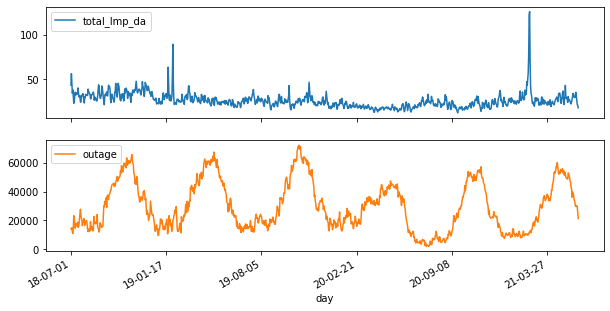

In [34]:
day_data[['total_lmp_da','outage']].plot(subplots=True)

In [35]:
day_data[['total_lmp_da','outage']].corr()

,total_lmp_da,outage
total_lmp_da,1.000000,-0.002991
outage,-0.002991,1.000000


### Answer:
Finally, we collect data on outage. We calculate the daily average LMP, and compare it with the daily outage amount. Surprsingly, it turns out that the outage amount has little correlation with LMP. However, it can be because the outage is distributed among the whole system, and does not directly impact the LMP at a specific node. However, if ISO has more detailed information on outage in the target area, this information should assist LMP forecasting.